In [1]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset

# These functions are introduced along the Part 1 notebook.

# Position vectors. We load the data with respect to the file name, which is
# a number corresponding to a specific in-bed position. We take advantage of this
# and use the number to get the position with help of the following vectors.

positions_i = ["justAPlaceholder", "supine", "right",
               "left", "right", "right",
               "left", "left", "supine",
               "supine", "supine", "supine",
               "supine", "right", "left",
               "supine", "supine", "supine"]

positions_ii = {
    "B":"supine", "1":"supine", "C":"right",
    "D":"left", "E1":"right", "E2":"right",
    "E3":"left", "E4":"left", "E5":"right",
    "E6":"left", "F":"supine", "G1":"supine",
    "G2":"right", "G3":"left"
}

# We also want the classes to be encoded as numbers so we can work easier when
# modeling. This function achieves so. Since left_fetus and right_fetus are not
# considered as classes in the evaluation of the original paper and since they
# are not considered in the "Experiment I", we encode them also as left and right
# positions.

class_positions = ['supine', 'left', 'right', 'left_fetus', 'right_fetus']

def token_position(x):
  return {
      'supine': 0,
      'left': 1,
      'right': 2,
      'left_fetus': 1,
      'right_fetus': 2
  }[x]

def load_exp_i(path):
  """
  Creates a numpy array for the data and labels.

  params:
  ------
  path    -- Data path.

  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        for file in files:
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            for line in f.read().splitlines()[2:]:

              raw_data = np.fromstring(line, dtype=float, sep='\t')
              # Change the range from [0-1000] to [0-255].
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              Normalize = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.ToTensor()
                          ])
              file_data = Normalize(file_data.reshape(64,32))
              file_data = file_data.view(1, 64, 32)
              # Turn the file index into position list,
              # and turn position list into reduced indices.
              file_label = token_position(positions_i[int(file[:-4])])
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
  return dataset

# Both air and sponge mattresses used in the data collection have a different
# size (64 x 27), opposed to the pressure mattress (64 x 32) used in the first
# experiment. Additionally, the image is rotated by 180 degrees with respect to
# the experiment one images.
# This function serves to set the format of the images equal to the ones taken
# by the pressure mat.

def resize_and_rotate(image):
  To_PIL_and_Resize = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((64, 32))
                      ])

  rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)

  return transforms.ToTensor()(rotated)


def load_exp_ii(path):

  exp_ii_data_air = {}
  exp_ii_data_spo = {}

  # each directory is a subject
  for _, subject_dirs, _ in os.walk(path):
    for subject in subject_dirs:
      data = None
      labels = None

      # each directory is a matresss
      for _, mat_dirs, _ in os.walk(os.path.join(path, subject)):
        for mat in mat_dirs:
          for _, _, files in os.walk(os.path.join(path, subject, mat)):
            for file in files:
              file_path = os.path.join(path, subject, mat, file)
              raw_data = np.loadtxt(file_path)
              # Change the range from [0-500] to [0-255].
              file_data = np.round(raw_data*255/500).astype(np.uint8)
              file_data = resize_and_rotate(file_data)
              file_data = file_data.view(1, 64, 32)

              if file[-6] == "E" or file[-6] == "G":
                file_label = positions_ii[file[-6:-4]]
              else:
                file_label = positions_ii[file[-6]]

              file_label = token_position(file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)

              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

          if mat == "Air_Mat":
            exp_ii_data_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
          else:
            exp_ii_data_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

          data = None
          labels = None

    return exp_ii_data_air, exp_ii_data_spo
  

def exp_i_cv():
  subjects_i = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", 
                "S8", "S9", "S10", "S11", "S12", "S13"]

  print("Performing one-subject-out cross validation on 'Experiment I':")

  torch.manual_seed(123)

  accuracies = []

  for subject in subjects_i:
    remaining_subjects = subjects_i.copy()
    remaining_subjects.remove(subject)

    trainset_exp_i = Mat_Dataset(["Base"], remaining_subjects)
    valset_exp_i = Mat_Dataset(["Base"], [subject])

    trainloader = DataLoader(trainset_exp_i, batch_size=64, shuffle=True)
    testloader = DataLoader(valset_exp_i, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CNN()

    criterion = nn.NLLLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    model.to(device)

    epochs = 15
    running_loss = 0

    train_losses, test_losses = [], []

    for epoch in range(epochs):
      for inputs, labels in trainloader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      else:

        test_loss = 0
        accuracy = 0
        model.eval()

        with torch.no_grad():
          for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            test_loss += criterion(logps, labels)

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        accuracy = accuracy/len(testloader)
        if (epoch + 1) == epochs:
          print(f"Leave out: {subject} - "
                f"Test accuracy: {accuracy:.3f}")
        running_loss = 0
        model.train()

    accuracies.append(accuracy)
  print(f"Results, one-subject-out cross validation: accuracy: {np.mean(accuracies):.3f}")
  
  
def train_all_exp_i():
  subjects_i = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", 
                "S8", "S9", "S10", "S11", "S12", "S13"]

  torch.manual_seed(123)

  trainset_exp_i = Mat_Dataset(["Base"], subjects_i)

  trainloader = DataLoader(trainset_exp_i, batch_size=64, shuffle=True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = CNN()

  criterion = nn.NLLLoss()

  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  model.to(device)

  epochs = 15
  running_loss = 0

  train_losses = []

  for epoch in range(epochs):
    for inputs, labels in trainloader:

      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    else:

      test_loss = 0
      accuracy = 0
      model.eval()

      with torch.no_grad():
        for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model.forward(inputs)
          test_loss += criterion(logps, labels)

          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))

      train_losses.append(running_loss/len(trainloader))
      
      accuracy = accuracy/len(testloader)
      if (epoch + 1) == epochs:
        print(f"Leave out: {subject} - "
              f"Test accuracy: {accuracy:.3f}")
      running_loss = 0
      model.train()
      
      return model, train_losses, accuracy

--2019-08-19 16:45:35--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’

a-pressure-map-data 100%[===================>] 102.34M  30.2MB/s    in 3.6s    

2019-08-19 16:45:41 (28.8 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’ saved [107315828/107315828]



In [0]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# [Part 2] - Introduction

This notebook belongs to a 4-parts project. This part is dedicated to build a model dedicated to classify human in-bed positions. On part one we tested a shallow model using a fully connected Multi-Layer-Perceptron. Now we want to improve our results and make a serious analysis that does not overestimate the model's performance.

# Data Preparation

## Data Loading

First we will load our datasets using our helper functions found on `helper.py`. Then we will gather all datasets into a dictionary:

In [0]:
exp_i_data = load_exp_i("dataset/experiment-i")
exp_ii_data_air, exp_ii_data_spo = load_exp_ii("dataset/experiment-ii")

datasets = {
    "Base":exp_i_data,
    "Spo":exp_ii_data_air,
    "Air":exp_ii_data_spo
}

## Creating a custom class

From the latter dictionary, `datasets`, we will create a custom **Dataset** class that we are going to use for our modeling. The idea is to define a class flexible enough so we can pull any subject data from any of the experiments.  For example, if our class is called `Mat_Dataset` and we we want to load the data of the subject n°1 and n°2 of the second experiment's sponge mat, then we would need to write:

`Mat_Dataset(mats=["Spo"], Subject_IDs=["S1", "S2"])`

We can take advantage of PyTorch's `Dataset` class to create ours. We just need to override two of the subclass functions:

+ the `len()` function (returns the size of the dataset)
+ the `getitem` function (returns a sample from the dataset)

In [0]:
from torch.utils.data import Dataset

class Mat_Dataset(Dataset):
  def __init__(self, mats, Subject_IDs):
    
    self.samples = []
    self.labels = []
    
    for mat in mats:
      data = datasets[mat]
      self.samples.append(np.vstack([data.get(key)[0] for key in Subject_IDs]))
      self.labels.append(np.hstack([data.get(key)[1] for key in Subject_IDs]))
      
    self.samples = np.vstack(self.samples)
    self.labels = np.hstack(self.labels)
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

In [5]:
# Sanity check:
# 1. There are 29 files (recordings) on S1's experiment-ii/Sponge_Mat/
print(f'Sanity check 1: {len(Mat_Dataset(["Spo"], ["S1"]))}')
# 2. If we take into account the air mat, then there should be 58 files
print(f'Sanity check 2: {len(Mat_Dataset(["Spo", "Air"], ["S1"]))}')
# 3. Let's load all experiment-i data and check that it works:
print(f'Sanity check 3: {len(Mat_Dataset(["Base"], [key for key in exp_i_data.keys()]))}')


Sanity check 1: 29
Sanity check 2: 58
Sanity check 3: 19582


## Splitting the data into training and testing set

In [0]:
trainset_exp_i = Mat_Dataset(["Base"], ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9"])

valset_exp_i = Mat_Dataset(["Base"], ["S10", "S11", "S12", "S13"])

trainloader = DataLoader(trainset_exp_i, batch_size=64, shuffle=True)
testloader = DataLoader(valset_exp_i, batch_size=64, shuffle=False)

# Modeling

## The proposed Convolutional Neural Network (CNN)

In [0]:
class CNN(nn.Module):
  
  def __init__(self):
    super().__init__()

    ## Convolutional Layers
    #Input channels = 1, output channels = 6
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    #Input channels = 6, output channels = 18
    self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)

    ## Pool Layer
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ## Mulit-Layer Perceptron
    # Hidden layers
    self.h1 = nn.Linear(18 * 16 * 8, 392)
    self.h2 = nn.Linear(392, 98)

    # Output layer, 3 neurons - one for each position
    self.output = nn.Linear(98, 3)

    # ReLU activation and softmax output 
    self.relu = nn.ReLU()
    self.logsoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):

    x = x.float()
    # Add a "channel dimension"
    x = x.unsqueeze(1)

    ## Computation on convolutional and pool layers:
    # Size changes from (1, 64, 32) to (6, 64, 32)
    x = F.relu(self.conv1(x))
    # Size changes from (6, 64, 32) to (6, 32, 16)
    x = self.pool(x)
    # Size changes from (6, 32, 16) to (18, 32, 16)
    x = F.relu(self.conv2(x))
    # Size changes from (18, 32, 16) to (18, 16, 8)
    x = self.pool(x)

    # Reshape data to input to the input layer of the MLP
    # Size changes from (18, 16, 8) to (1, 2304)
    x = x.view(x.shape[0], -1)
    
    ## Computation on the MLP layers:
    x = self.h1(x)
    x = self.relu(x)
    x = self.h2(x)
    x = self.relu(x)
    x = self.output(x)
    x = self.logsoftmax(x)

    return x

In [0]:
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = CNN()

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=3, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

In [10]:
epochs = 15
running_loss = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
  
    inputs, labels = inputs.to(device), labels.to(device)
  
    optimizer.zero_grad()

    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else:
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        test_loss += criterion(logps, labels)
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    if (epoch + 1) % 3 == 0:
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/len(trainloader):.3f}.. "
            f"Test loss: {test_loss/len(testloader):.3f}.. "
            f"Test accuracy: {accuracy/len(testloader):.3f}")
    running_loss = 0
    model.train()

Epoch 3/15.. Train loss: 0.005.. Test loss: 0.134.. Test accuracy: 0.952
Epoch 6/15.. Train loss: 0.000.. Test loss: 0.210.. Test accuracy: 0.966
Epoch 9/15.. Train loss: 0.000.. Test loss: 0.175.. Test accuracy: 0.961
Epoch 12/15.. Train loss: 0.000.. Test loss: 0.181.. Test accuracy: 0.963
Epoch 15/15.. Train loss: 0.000.. Test loss: 0.186.. Test accuracy: 0.962


## Evaluation

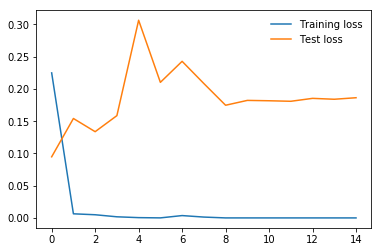

In [11]:
fig = plt.plot(train_losses, label='Training loss')
fig = plt.plot(test_losses, label='Test loss')
fig = plt.legend(frameon=False)  

Our model seems to work really well! Let's see it in action by plotting some images and the corresponding prediction:

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')


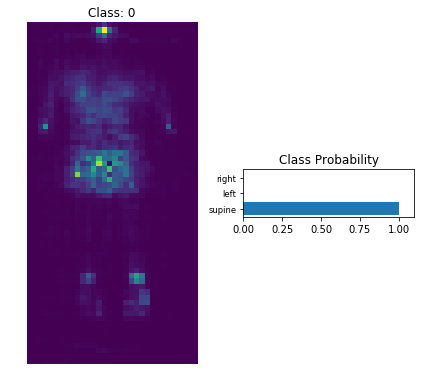

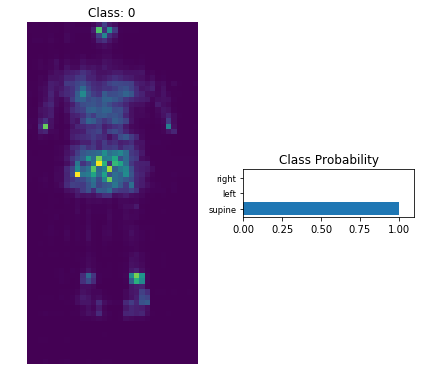

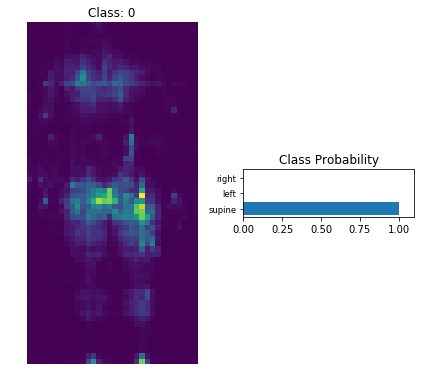

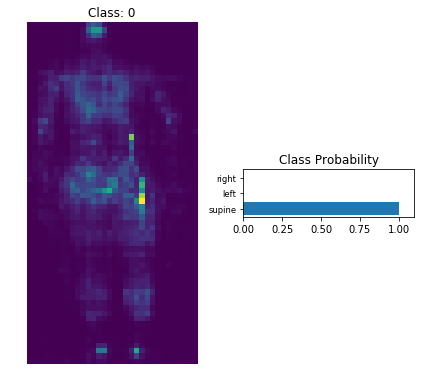

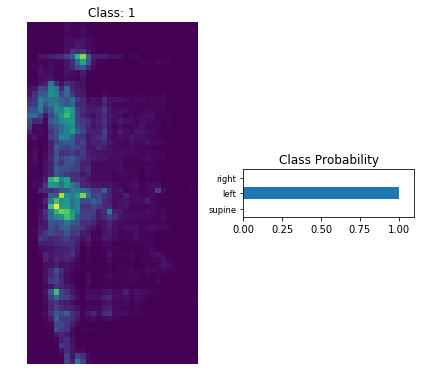

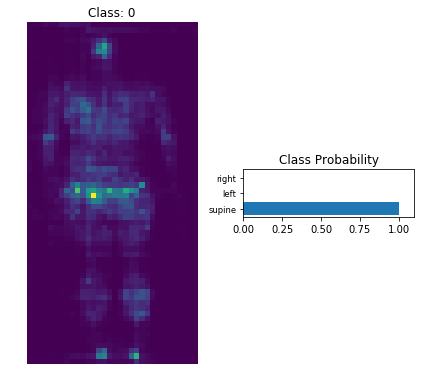

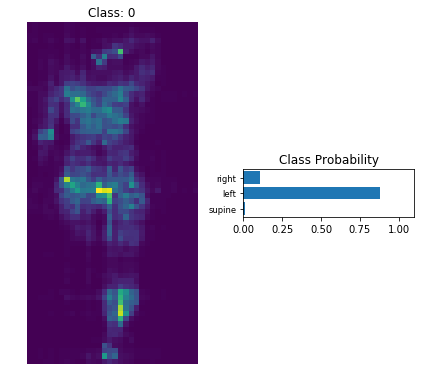

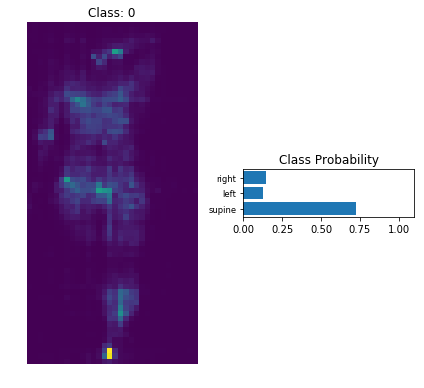

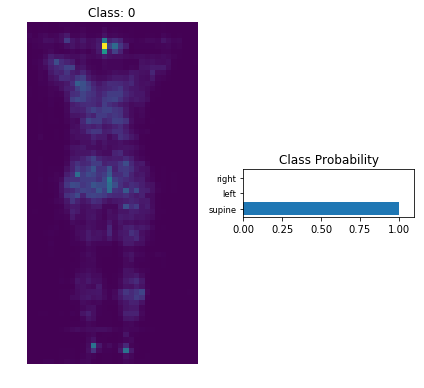

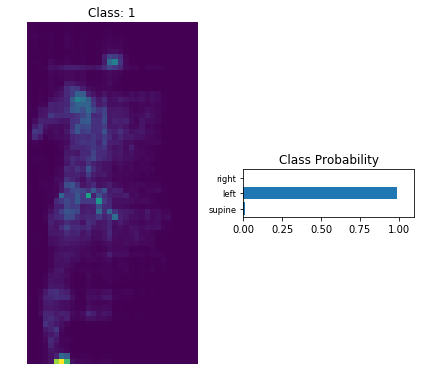

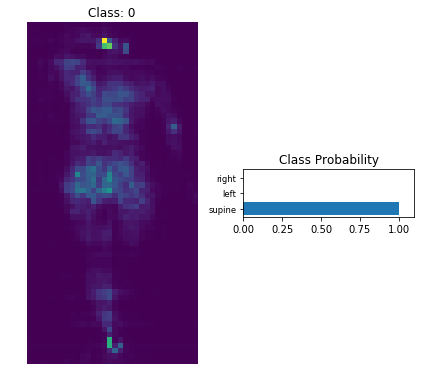

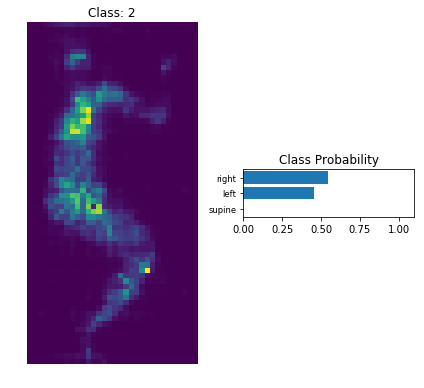

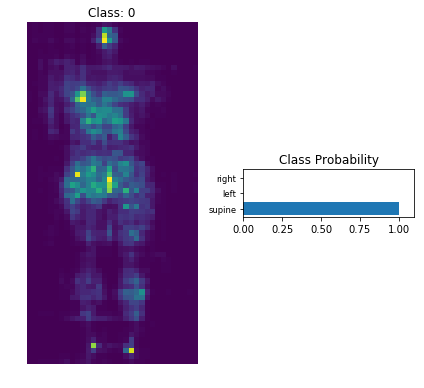

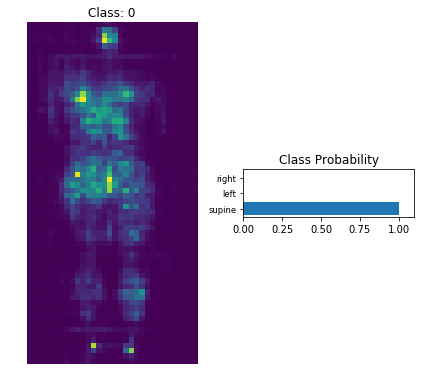

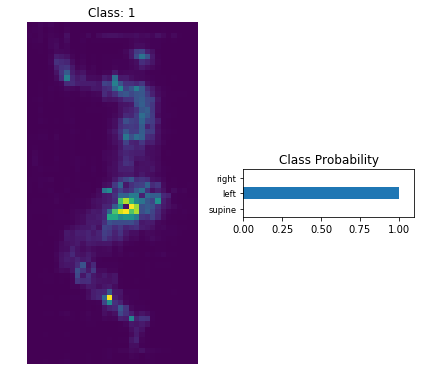

In [12]:
def class_position(img, ps, label):
  ''' Function for viewing an positioin and it's predicted classes.
  '''
  ps = ps.data.numpy().squeeze()

  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1.imshow(img.resize_(1, 64, 32).numpy().squeeze())
  ax1.axis('off')
  ax1.set_title(f'Class: {label}') 
  ax2.barh(np.arange(3), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(3))

  ax2.set_yticklabels(['supine', 'left', 'right'], size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

i = 1
for inputs, labels in testloader:
  inputs, labels = inputs.to(device), labels.to(device)
  class_position(inputs[0].unsqueeze(0).cpu(), torch.exp(model.forward(inputs[0].unsqueeze(0))).cpu(), labels[0].cpu())
  print(labels[0])
  if i >= 15:
    break
  i += 1

We just obtained an estimate of the performance of our model with unseen data, where we purposely chose "S10", "S11", "S12", and "S13" as our test subjects. Now we want to perform a **leave-one-subject-out cross validation**, a technique that allow us to calculate a much better estimate for our model. Basically, the purpose is to select one subject as the testing set and use the rest as training, create and train a model, calculate its accuracy, and then repeat this procedure for all subjects. Finally, the mean value of all accuracies gives us the estimate of the performance of our model.

Since this technique involves only the repetition of code that we already introduced above, we created a function (found in `helper.py`)  `exp_i_cv()` for this purpose and we will just call it here to see the results, avoiding displaying redundant code in this notebook.

In [13]:
exp_i_cv()

Performing one-subject-out cross validation on 'Experiment I':
Leave out: S1 - Test accuracy: 0.981
Leave out: S2 - Test accuracy: 0.947
Leave out: S3 - Test accuracy: 1.000
Leave out: S4 - Test accuracy: 0.892
Leave out: S5 - Test accuracy: 1.000
Leave out: S6 - Test accuracy: 1.000
Leave out: S7 - Test accuracy: 0.993
Leave out: S8 - Test accuracy: 0.911
Leave out: S9 - Test accuracy: 1.000
Leave out: S10 - Test accuracy: 0.895
Leave out: S11 - Test accuracy: 0.990
Leave out: S12 - Test accuracy: 1.000
Leave out: S13 - Test accuracy: 0.937
Results, one-subject-out cross validation: accuracy: 0.965


Overall we obtained a great accuracy on this dataset, which is bigger than the ones reported by _Pouyan et. al (2017)_ on their [paper](https://ieeexplore.ieee.org/document/7897206/):

![Pouyan et. al - Results](img/Pouyan_et_al_Results.png) 

This positive result also stresses the advantages of using CNNs, compared with traditional methods such as the one used by the authors mentioned, where they performed a manual feature extraction and fed those features to a MLP.

## Testing the model on Experiment II data

intro to CNN
train mode alone
use imgview to exp ii

We want to test how well does the model perform on data that was recorded on 'Experiment II', for that we will train a model using *all data* contained in 'Experiment I'. This training procedure is almost equal to what we just did, so we encapsulated it in a function: `train_all_exp_i()`



In [0]:
model, train_losses, accuracy = train_all_exp_i()

In [15]:
dataset_exp_ii = Mat_Dataset(["Spo", "Air"], exp_ii_data_spo.keys())

loader = DataLoader(dataset_exp_ii, batch_size=64, shuffle=False)
accuracy = 0

model.eval()
with torch.no_grad():
  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f"Test accuracy: {accuracy/len(loader):.3f}")

Test accuracy: 0.543


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


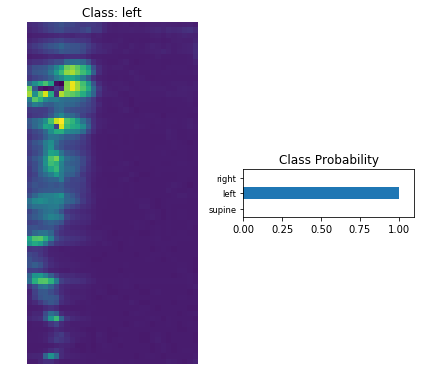

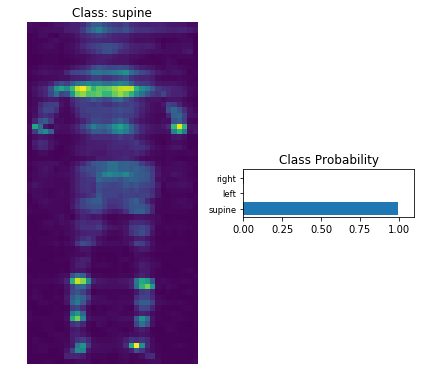

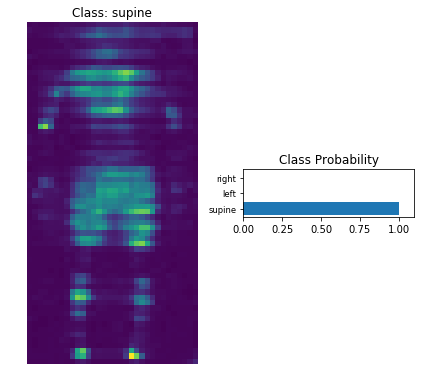

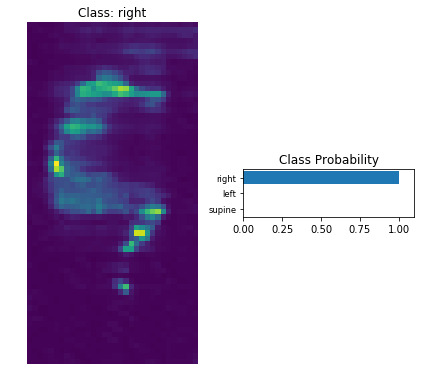

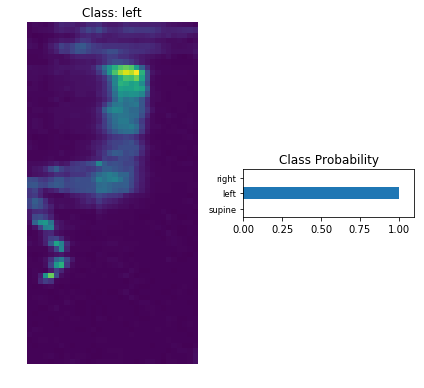

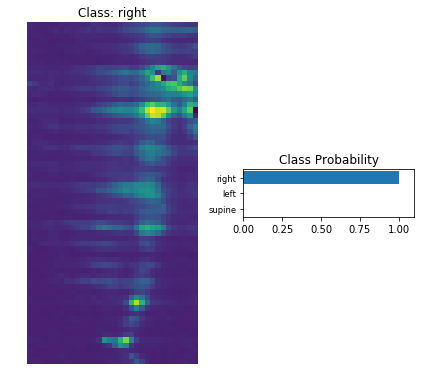

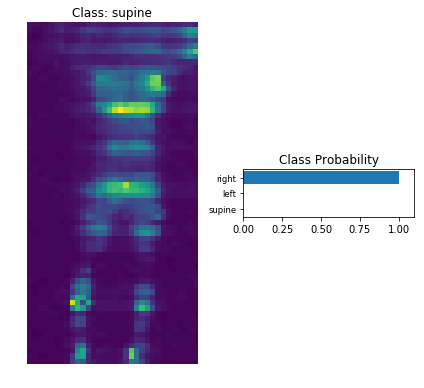

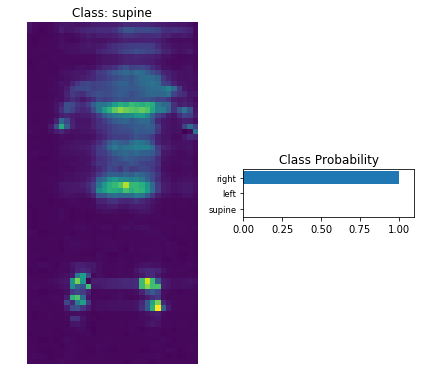

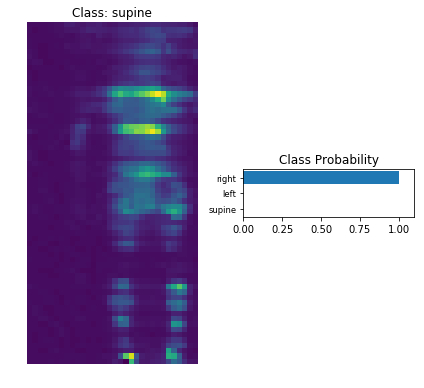

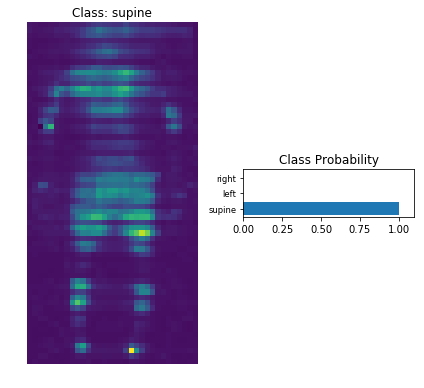

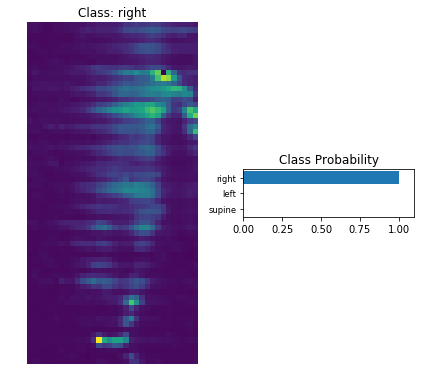

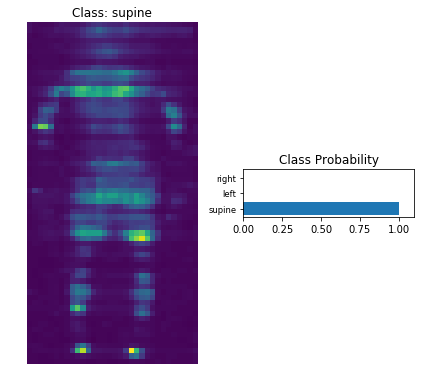

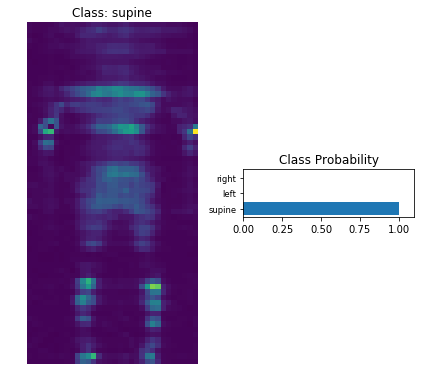

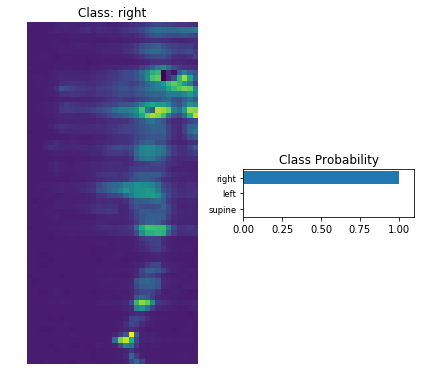

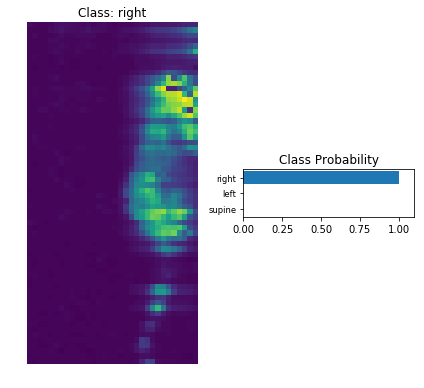

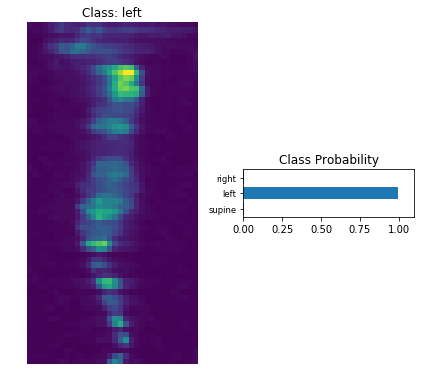

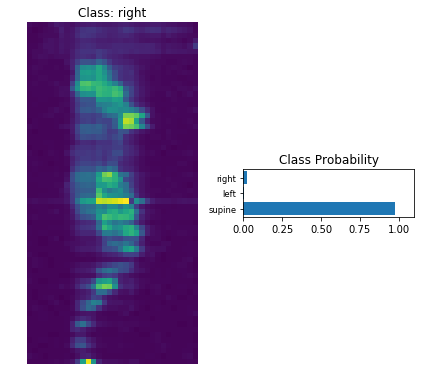

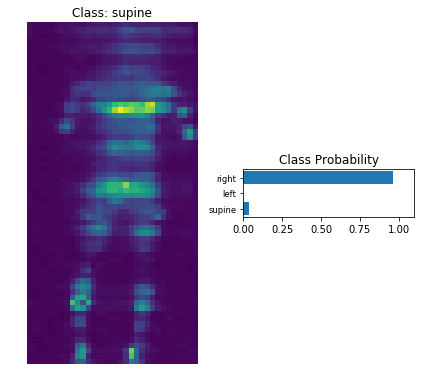

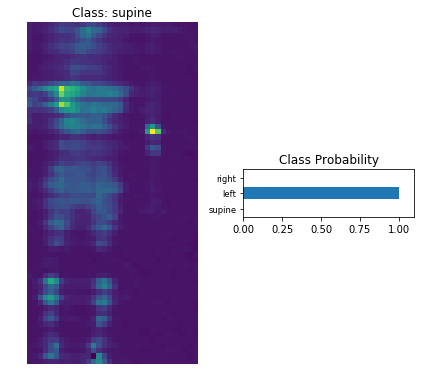

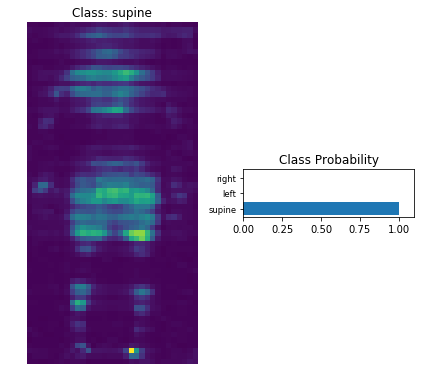

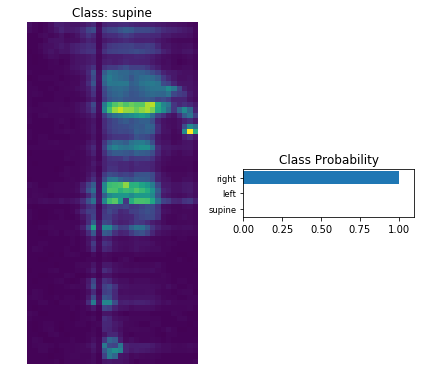

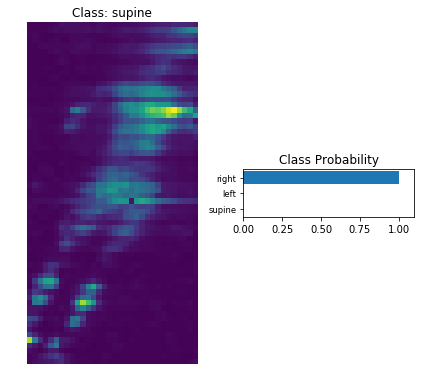

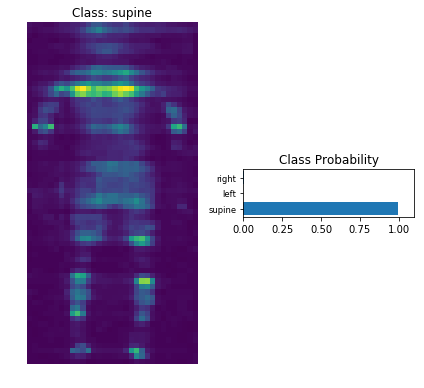

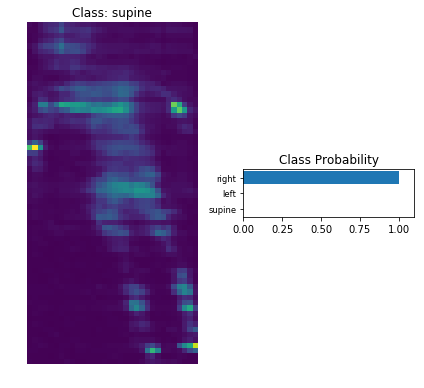

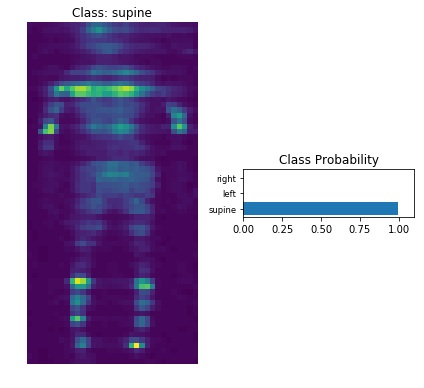

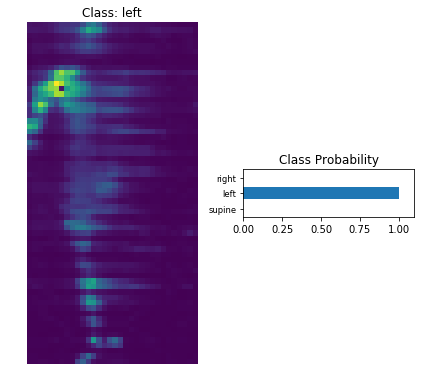

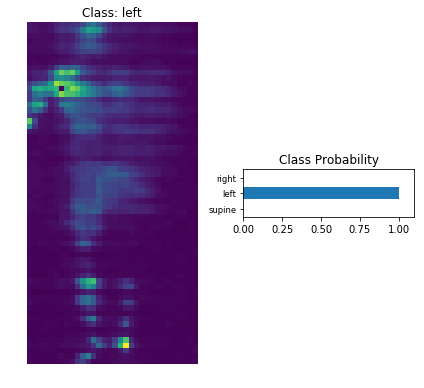

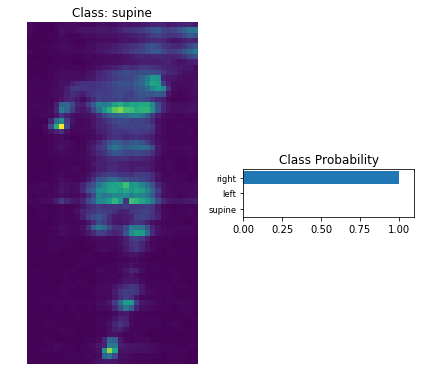

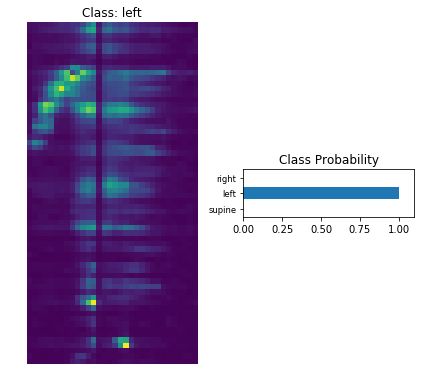

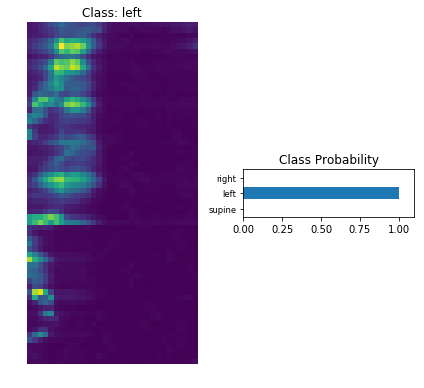

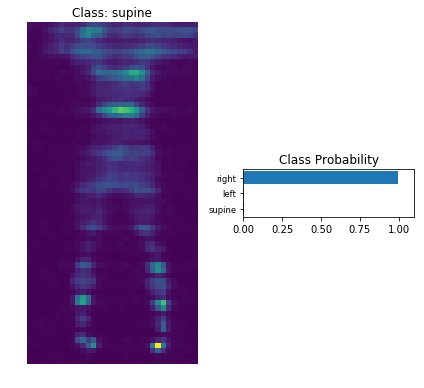

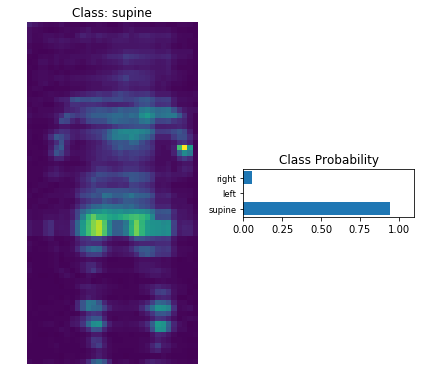

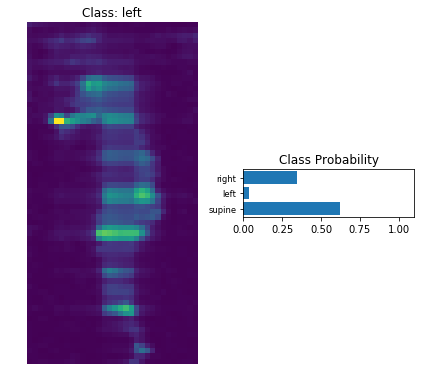

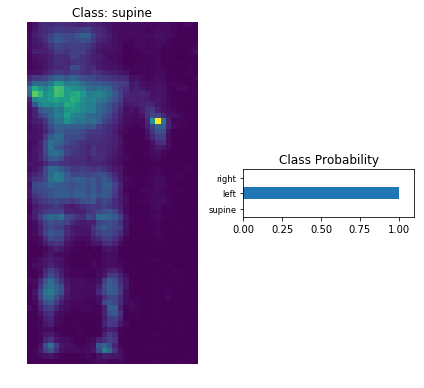

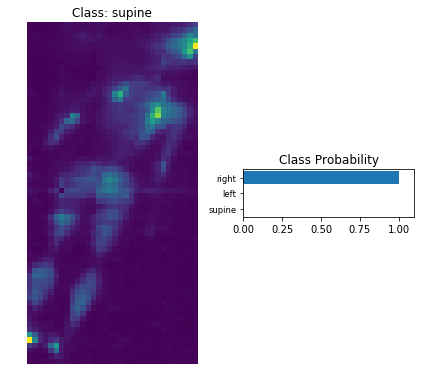

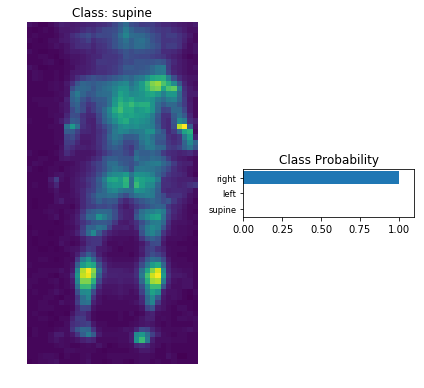

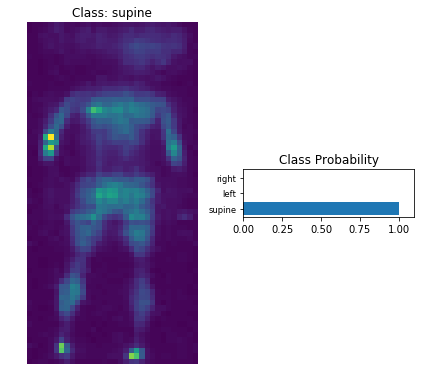

In [17]:
i = 1
for inputs, labels in loader:
  inputs, labels = inputs.to(device), labels.to(device)
  for j in range(labels.shape[0]):
    image = inputs[j]
    label = labels[j]
    img = image.unsqueeze(0).cpu()
    ps = torch.exp(model.forward(image.unsqueeze(0))).cpu()
    class_position(img, ps, class_positions[label.cpu()])
    if i >= 30:
      break
    i += 1